# Convolutional Neural Network for GDP Time Series Forecasting

In [26]:
# load relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from cnn_model import CNN_1D
from windowing import WindowGenerator

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# load cleaned data
df = pd.read_csv('data_cleaned.csv')
df.rename(columns={df.columns[0]: 'Index'}, inplace=True)
df.set_index('Index', inplace=True)

df

,"Gross Domestic Product, Year On Year Growth Rate | GDP In Chained (2015) Dollars","Food & Beverage Services Index, (2017 = 100), In Chained Volume Terms | Total","Retail Sales Index, (2017 = 100), In Chained Volume Terms | Total",Sea Cargo And Shipping Statistics (Total Cargo) | Total Container Throughput (Thousand Twenty-Foot Equivalent Units),Air Cargo Tonnage | Total Direct Tonnage (Tonne),Merchandise Imports By Commodity Division | Total Merchandise Imports,M1 Money Supply,Index Of Industrial Production (2019 = 100) | Total,Domestic Exports Of Major Non-Oil Products | Total Electronic Products,Composite Leading Index (2015 = 100) | Quarterly Composite Leading Index,"Business Expectations For The Services Sector - General Business Outlook For The Next 6 Months, Weighted Percentages Of Up, Same, Down | Net Weighted Balance - Total Services Sector","Domestic Wholesale Trade Index, (2017 = 100), In Chained Volume Terms | Total","Foreign Wholesale Trade Index, (2017 = 100), In Chained Volume Terms | Total",Job Vacancies By Industry And Occupational Group (SSIC 2020) (End Of Period) | Total,Unemployment Rate (End Of Period) | Total Unemployment Rate
Index,,,,,,,,,,,,,,,
1997-01-31,5.766667,111.147,15.715098,5.488212,93891.4,1.600448,9.938033,-5.407013,-0.636598,2.039052,5.333333,-4.953253,4.805478,-6.735186,-14.074074
1997-02-28,5.733333,109.571,-19.711470,0.511269,95647.4,-11.022186,6.894096,-3.535354,-5.900391,2.393572,3.666667,-1.013923,6.974227,-5.116564,-17.037037
1997-03-31,5.700000,118.447,3.658993,16.211454,94048.8,1.893330,9.790800,-6.288319,-5.065484,2.748092,2.000000,2.925407,9.142976,-3.497942,-20.000000
1997-04-30,6.966667,107.974,2.971000,9.481268,94470.6,2.179168,4.434663,2.294903,-1.744494,3.147185,8.666667,6.860232,10.549475,-3.759513,-20.277778
1997-05-31,8.233333,113.795,2.081662,7.937089,94257.8,6.845282,5.632341,0.208366,-7.157538,3.546278,15.333333,10.795056,11.955975,-4.021084,-20.555556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,2.733333,94.672,3.528764,-6.174603,99219.0,-0.041443,3.938170,-3.701242,-20.219001,-3.943664,5.000000,-2.638300,1.877809,-5.648494,-16.190476
2022-12-31,2.100000,102.994,4.257838,-1.193731,99029.0,-8.242208,6.151695,-3.505964,-17.856474,-5.422222,3.000000,-0.911467,1.223659,-9.912281,-14.285714
2023-01-31,1.533333,99.578,-4.899654,-4.905048,85680.0,-11.227587,6.068394,-3.013121,-26.816758,-5.461702,3.333333,2.834411,0.420000,-5.828636,-16.190476


## Data Preprocessing

In this section, the following steps will be performed in sequence.

1. split data into train and test (0.8:0.2)
    - train duration: 1997 - 2017
    - test duration 2018 - 2023
2. Perform scaling on the dataset; specifically
    - fit transform train
    - transform test to prevent data leakage
    - X, y are scale separately so that the y_pred can be inverse_transform subsequently.

In [3]:
# manual split data so that we can train and test for specific year ranges
train = df[(df.index < "2018-01-31")].copy()
test = df[df.index >= "2018-01-31"].copy()
total = df.copy()
total_dateindex = df.index
train_dateindex = train.index
test_dateindex = test.index

In [4]:
target_col = 'Gross Domestic Product, Year On Year Growth Rate | GDP In Chained (2015) Dollars'
X = df.drop(target_col, axis =1)
y = df[target_col] 

X_train = X[(X.index < "2018-01-31")].copy()
X_test = X[X.index >= "2018-01-31"].copy()
y_train = y[(y.index < "2018-01-31")].copy()
y_test = y[y.index >= "2018-01-31"].copy()

scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = y_scaler.fit_transform(y_train.values.reshape(-1,1))
y_test = y_scaler.transform(y_test.values.reshape(-1,1))
X_total = scaler.transform(X)
y_total = y_scaler.transform(y.values.reshape(-1,1))

## Single Conv1d Model

In [5]:
batch_size=18

# train and test dataloaders for lookback=6, lookahead=1
lookback=6
lookahead=1
learning_rate = 0.001
n_features = 15
num_epochs = 200

In [6]:
total_dataloader1 = WindowGenerator(X_total, y_total,
                                  lookback=lookback,
                                  lookahead=lookahead,
                                  batch_size=batch_size).make_dataloader()

train_dataloader1 = WindowGenerator(X_train, y_train,
                                  lookback=lookback,
                                  lookahead=lookahead,
                                  batch_size=batch_size).make_dataloader()

test_dataloader1 = WindowGenerator(X_test, y_test,
                                 lookback=lookback,
                                 lookahead=lookahead,
                                 batch_size=batch_size).make_dataloader()

torch.device => mps


  0%|                                                                       | 0/200 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target s

Epoch 1/200, Loss: 0.2619 Val loss:2.4348
Epoch 2/200, Loss: 0.0727 Val loss:1.4738
Epoch 3/200, Loss: 0.0925 Val loss:1.9530


  2%|█▎                                                             | 4/200 [00:00<00:10, 18.23it/s]

Epoch 4/200, Loss: 0.0539 Val loss:1.7091


  4%|██▏                                                            | 7/200 [00:00<00:09, 19.97it/s]

Epoch 5/200, Loss: 0.0333 Val loss:1.7683
Epoch 6/200, Loss: 0.0280 Val loss:1.7998
Epoch 7/200, Loss: 0.0240 Val loss:1.6214
Epoch 8/200, Loss: 0.0196 Val loss:1.6738
Epoch 9/200, Loss: 0.0161 Val loss:1.8988


  6%|███▋                                                          | 12/200 [00:00<00:09, 19.72it/s]

Epoch 10/200, Loss: 0.0306 Val loss:1.7165
Epoch 11/200, Loss: 0.0521 Val loss:1.2182
Epoch 12/200, Loss: 0.0451 Val loss:1.9569
Epoch 13/200, Loss: 0.0228 Val loss:2.3989
Epoch 14/200, Loss: 0.0753 Val loss:1.1492


  9%|█████▌                                                        | 18/200 [00:00<00:08, 21.41it/s]

Epoch 15/200, Loss: 0.0682 Val loss:2.3927
Epoch 16/200, Loss: 0.0245 Val loss:1.3582
Epoch 17/200, Loss: 0.0228 Val loss:2.0948
Epoch 18/200, Loss: 0.0219 Val loss:1.4880
Epoch 19/200, Loss: 0.0127 Val loss:1.8472


 10%|██████▌                                                       | 21/200 [00:00<00:07, 22.41it/s]

Epoch 20/200, Loss: 0.0162 Val loss:1.6040
Epoch 21/200, Loss: 0.0120 Val loss:1.6745
Epoch 22/200, Loss: 0.0113 Val loss:1.7441
Epoch 23/200, Loss: 0.0132 Val loss:1.6349
Epoch 24/200, Loss: 0.0111 

 12%|███████▏                                                      | 23/200 [00:01<00:08, 20.45it/s]

Val loss:1.6129
Early stopping at epoch 24


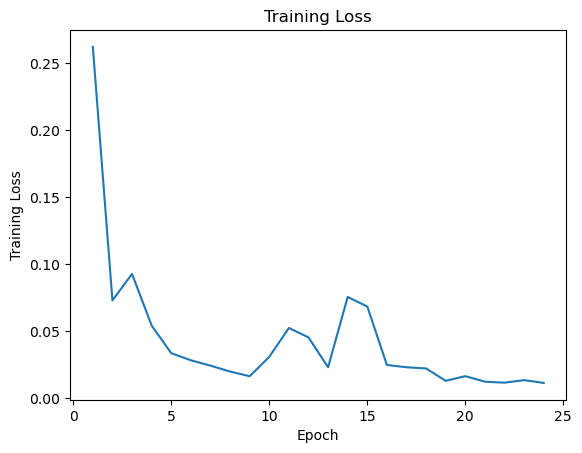

In [11]:
# Initialize the model and the optimizer
model_single = CNN_1D(n_features, lookback, layers ="single")
model_single.set_device()
criterion = nn.MSELoss() 
optimizer = optim.Adam(model_single.parameters(), lr=learning_rate)


model_single.fit(train_dataloader1, test_dataloader1, num_epochs,
                    criterion, optimizer, min_delta=1e-4, patience=10)

In [12]:
model_single.evaluate(test_dataloader1, criterion, y_scaler)

Test Loss: 2.0272, MSE: 20.0426, RMSE: 3.7642, MAE: 3.3118


/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lea

In [30]:
torch.save(model_single, 'model_single.pth')

torch.device => mps


  0%|                                                                       | 0/200 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target siz

Epoch 1/200, Loss: 0.4540 Val loss:4.5642
Epoch 2/200, Loss: 0.0420 Val loss:1.7591


  2%|█▎                                                             | 4/200 [00:00<00:11, 16.67it/s]

Epoch 3/200, Loss: 0.0643 Val loss:2.2290
Epoch 4/200, Loss: 0.0343 Val loss:2.3590


  3%|█▉                                                             | 6/200 [00:00<00:11, 16.65it/s]

Epoch 5/200, Loss: 0.0129 Val loss:2.1042
Epoch 6/200, Loss: 0.0096 Val loss:2.4507


  4%|██▌                                                            | 8/200 [00:00<00:11, 16.98it/s]

Epoch 7/200, Loss: 0.0069 Val loss:2.0082
Epoch 8/200, Loss: 0.0068 Val loss:2.4047


  5%|███                                                           | 10/200 [00:00<00:10, 17.35it/s]

Epoch 9/200, Loss: 0.0065 Val loss:2.2559
Epoch 10/200, Loss: 0.0078 Val loss:2.2005
Epoch 11/200, Loss: 0.0059 

  6%|███▍                                                          | 11/200 [00:00<00:11, 16.03it/s]

Val loss:2.1585
Epoch 12/200, Loss: 0.0054 Val loss:2.5212
Early stopping at epoch 12


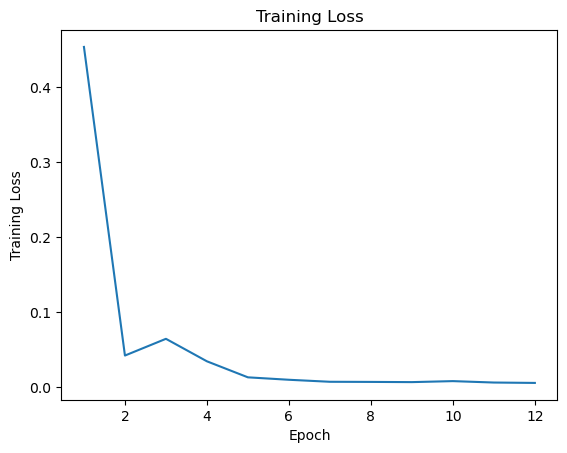

In [16]:
batch_size=18

# train and test dataloaders for lookback=12, lookahead=1
lookback=12
lookahead=1
learning_rate = 0.001
n_features = 15
num_epochs = 200

total_dataloader12 = WindowGenerator(X_total, y_total,
                                  lookback=lookback,
                                  lookahead=lookahead,
                                  batch_size=batch_size).make_dataloader()

train_dataloader12 = WindowGenerator(X_train, y_train,
                                  lookback=lookback,
                                  lookahead=lookahead,
                                  batch_size=batch_size).make_dataloader()

test_dataloader12 = WindowGenerator(X_test, y_test,
                                 lookback=lookback,
                                 lookahead=lookahead,
                                 batch_size=batch_size).make_dataloader()

# Initialize the model and the optimizer
model_single12 = CNN_1D(n_features, lookback, layers ="single")
model_single12.set_device()
criterion = nn.MSELoss() 
optimizer = optim.Adam(model_single12.parameters(), lr=learning_rate)


model_single12.fit(train_dataloader12, test_dataloader12, num_epochs,
                    criterion, optimizer, min_delta=1e-4, patience=10)

In [17]:
model_single12.evaluate(test_dataloader12, criterion, y_scaler)

Test Loss: 2.4951, MSE: 27.5463, RMSE: 5.1211, MAE: 4.0978


/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [29]:
torch.save(model_single12, 'model_single12.pth')

## Multi Layer Conv1d Model

torch.device => mps


  0%|                                                                       | 0/200 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|▎                                                              | 1/200 [00:00<00:44,  4.49it/s]

Epoch 1/200, Loss: 0.0136 Val loss:1.5939


  1%|▋                                                              | 2/200 [00:00<00:51,  3.87it/s]

Epoch 2/200, Loss: 0.0650 Val loss:1.6453
Epoch 3/200, Loss: 0.3677 

  2%|▉                                                              | 3/200 [00:00<00:46,  4.23it/s]

Val loss:2.5089


  2%|█▎                                                             | 4/200 [00:00<00:46,  4.24it/s]

Epoch 4/200, Loss: 0.0472 Val loss:1.5947


  2%|█▌                                                             | 5/200 [00:01<00:43,  4.44it/s]

Epoch 5/200, Loss: 0.0339 Val loss:2.0866


  3%|█▉                                                             | 6/200 [00:01<00:43,  4.42it/s]

Epoch 6/200, Loss: 0.0305 Val loss:1.6325


  4%|██▏                                                            | 7/200 [00:01<00:46,  4.15it/s]

Epoch 7/200, Loss: 0.0068 Val loss:1.6173


  4%|██▌                                                            | 8/200 [00:01<00:49,  3.86it/s]

Epoch 8/200, Loss: 0.0989 Val loss:2.7426


  4%|██▊                                                            | 9/200 [00:02<00:48,  3.93it/s]

Epoch 9/200, Loss: 0.1743 Val loss:1.4816


  5%|███                                                           | 10/200 [00:02<00:47,  4.00it/s]

Epoch 10/200, Loss: 0.0139 Val loss:1.6328


  6%|███▍                                                          | 11/200 [00:02<00:48,  3.90it/s]

Epoch 11/200, Loss: 0.0637 Val loss:2.2743


  6%|███▋                                                          | 12/200 [00:02<00:47,  3.97it/s]

Epoch 12/200, Loss: 0.0044 Val loss:1.8461


  6%|████                                                          | 13/200 [00:03<00:47,  3.93it/s]

Epoch 13/200, Loss: 0.0384 Val loss:1.7877


  7%|████▎                                                         | 14/200 [00:03<00:46,  4.00it/s]

Epoch 14/200, Loss: 0.0096 Val loss:2.0138
Epoch 15/200, Loss: 0.0050 

  8%|████▋                                                         | 15/200 [00:03<00:43,  4.26it/s]

Val loss:1.9698


  8%|████▉                                                         | 16/200 [00:03<00:45,  4.04it/s]

Epoch 16/200, Loss: 0.0143 Val loss:2.1632


  8%|█████▎                                                        | 17/200 [00:04<00:44,  4.10it/s]

Epoch 17/200, Loss: 0.0400 Val loss:2.3900


  9%|█████▌                                                        | 18/200 [00:04<00:43,  4.18it/s]

Epoch 18/200, Loss: 0.0045 Val loss:1.7702


  9%|█████▌                                                        | 18/200 [00:04<00:47,  3.85it/s]

Epoch 19/200, Loss: 0.0053 Val loss:1.9483
Early stopping at epoch 19


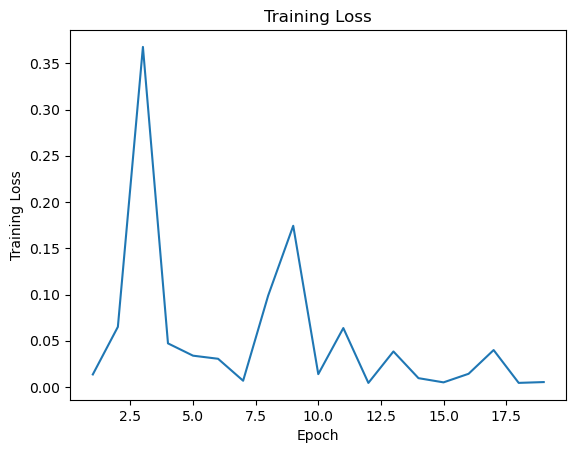

In [20]:
batch_size=18

# train and test dataloaders for lookback=6, lookahead=1
lookback=12
lookahead=1
learning_rate = 0.001
n_features = 15
num_epochs = 200

total_dataloader3 = WindowGenerator(X_train, y_train,
                                  lookback=lookback,
                                  lookahead=lookahead,
                                  batch_size=batch_size).make_dataloader()

train_dataloader3 = WindowGenerator(X_train, y_train,
                                  lookback=lookback,
                                  lookahead=lookahead,
                                  batch_size=batch_size).make_dataloader()

test_dataloader3 = WindowGenerator(X_test, y_test,
                                 lookback=lookback,
                                 lookahead=lookahead,
                                 batch_size=batch_size).make_dataloader()

# Initialize the model and the optimizer
model_multi = CNN_1D(n_features, lookback, layers ="multi")
model_multi.set_device()
criterion = nn.MSELoss() 
optimizer = optim.Adam(model_multi.parameters(), lr=learning_rate)


model_multi.fit(train_dataloader3, test_dataloader3, num_epochs,
                    criterion, optimizer, min_delta=1e-4, patience=10)

In [22]:
model_multi.evaluate(test_dataloader3, criterion, y_scaler)

Test Loss: 1.9991, MSE: 19.0634, RMSE: 4.3458, MAE: 3.2255


/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely l

In [31]:
torch.save(model_multi, 'model_multi.pth')

## Visualize Results

In [24]:
def plot_predictions(model, 
                     test_loader, 
                     test_dateindex,
                     lookback,
                     lookahead,
                     y_scaler,
                     title=""
                     ):
    y_pred = model.predict(torch.Tensor(np.array(test_loader.dataset.X)))
    y_pred = y_pred.cpu().detach()
    y_pred = y_scaler.inverse_transform(y_pred.reshape(-1,1))
    
    start = lookback
    end = len(test_dateindex) - lookahead   

    fig, axs = plt.subplots(1,1, figsize=(10,8), constrained_layout=True)
    true_y = y_scaler.inverse_transform(test_loader.dataset.y.reshape(-1,1))

    axs.plot(test_dateindex[start:end], 
            true_y, 
            linewidth=1, alpha=0.5, 
            color='#000099', label='y_true')

    axs.plot(test_dateindex[start:end], 
            y_pred, 
            linewidth=1, alpha=0.5, 
            color='#ff0000', label='y_pred')

    axs.legend()

    axs.set_title(title)
    plt.xticks(rotation=45)
    x_labels = axs.get_xticklabels()
    for i, label in enumerate(x_labels):
        if i % 6 != 0:
            label.set_visible(False)

    plt.show()

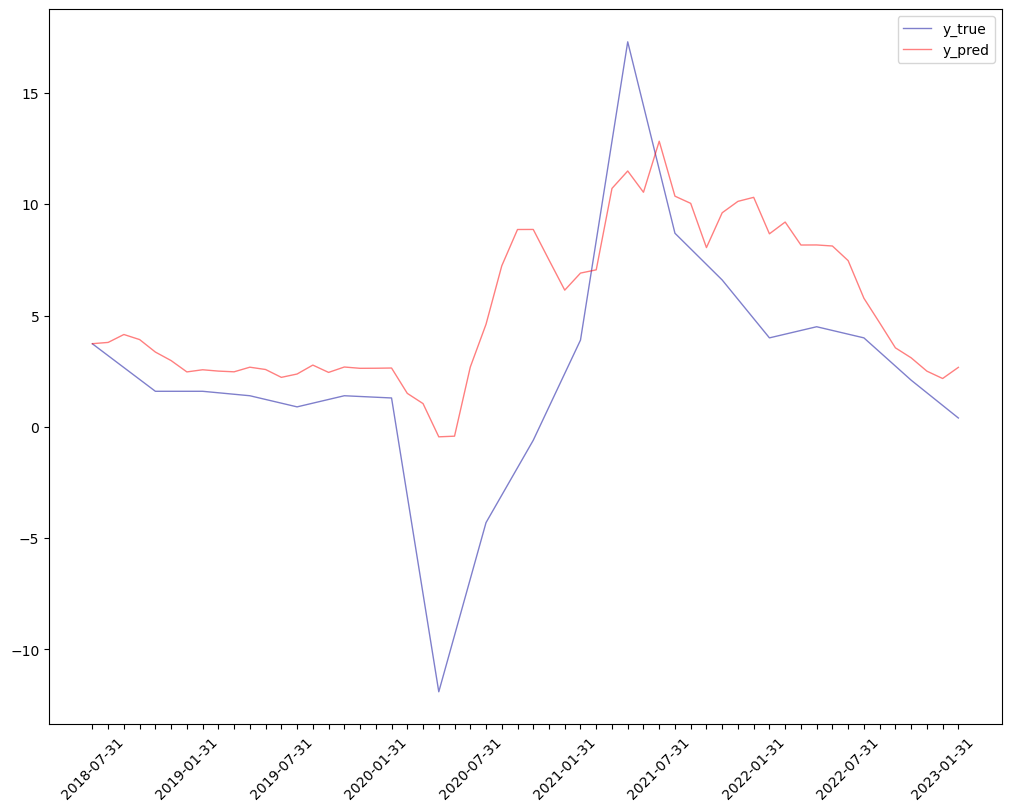

In [27]:
lookback = 6
lookahead = 1
plot_predictions(model_single, test_dataloader1,
                 test_dateindex, lookback, lookahead, y_scaler)

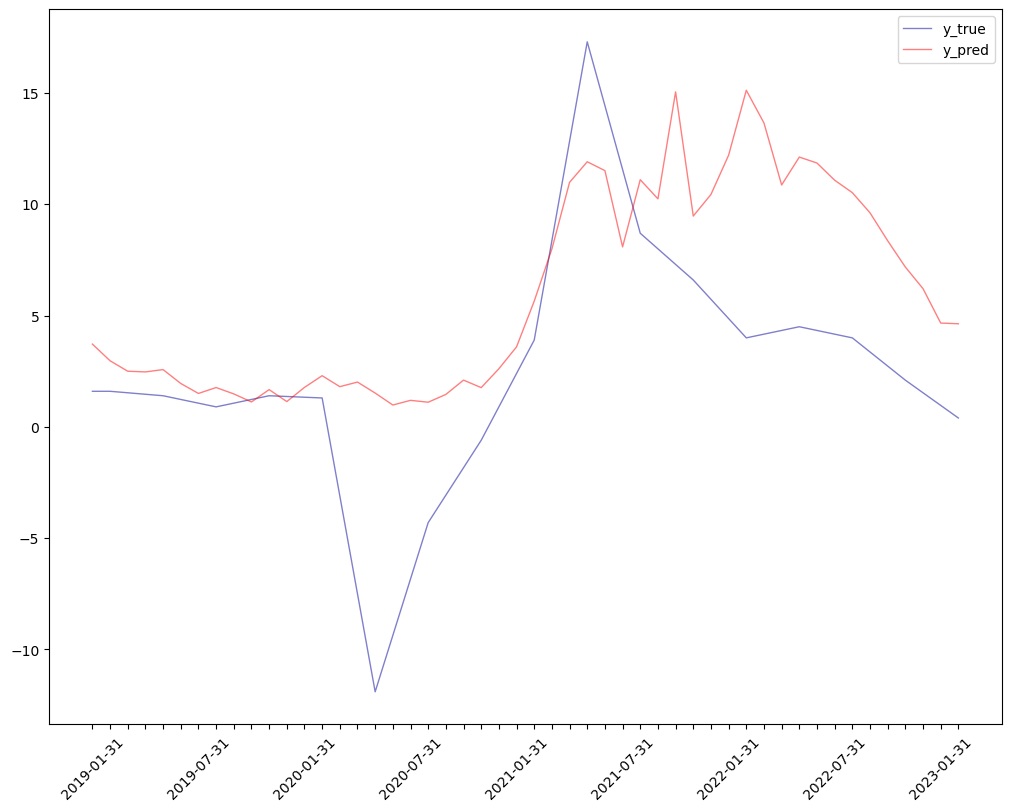

In [33]:
lookback = 12
lookahead = 1
plot_predictions(model_single12, test_dataloader12,
                 test_dateindex, lookback, lookahead, y_scaler)

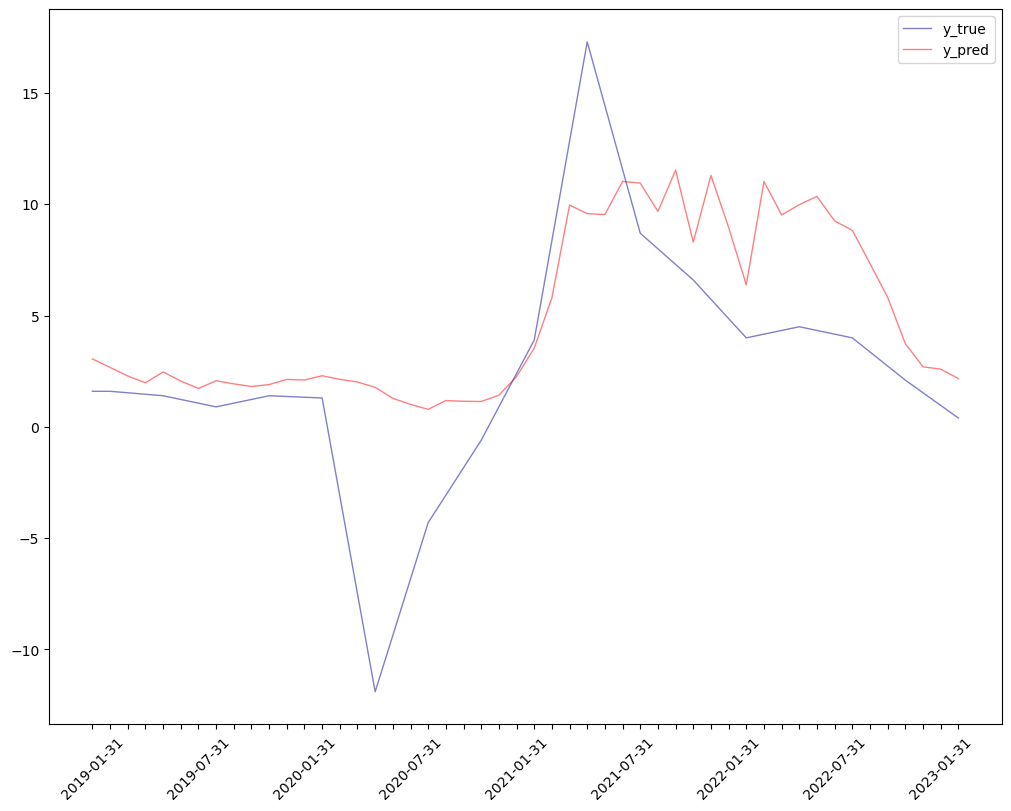

In [34]:
lookback = 12
lookahead = 1
plot_predictions(model_multi, test_dataloader3,
                 test_dateindex, lookback, lookahead, y_scaler)